<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Data_Sprint_45_Sign_Language_Hand_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

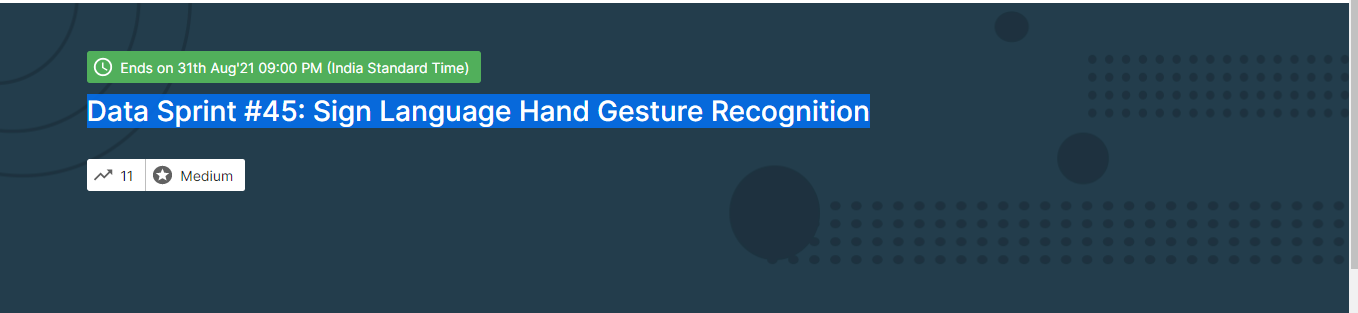

## Problem Overview
New technologies are emerging that can assist those with hearing disabilities, but there is still plenty of work to be done. Computer vision applications, for example, could improve communication with the deaf and hard-of-hearing even more due to advancements in machine learning algorithms.

 
## Problem Statement
You are required to build a machine learning model that is capable of identifying American Sign Language (ASL) hand gestures. 

## Evaluation

Submissions are evaluated using Accuracy Score.

## Data Description

train - contains all the images that are to be used for training your model.

Training_set.csv - this csv file has contains the labels for the training images

test - contains 26000+ images. For these images you are required to make predictions

Testing_set.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you submit are with their image’s filename in the same order as given in this file.

sample_submission.csv- this is the sample submission file for the data sprint

 

## Getting Started Code For Data Sprint #45 on DPhi

## Download Images

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1QtuAY57-FVeMiDHExgYN4-kEgGElQYH-',
dest_path='content/asl_alphabets.zip',
unzip=True)

Unzipping...Done.


In [2]:
%%capture
!pip install ipyplot

## Loading Libraries

In [3]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score, accuracy_score
import cv2
import ipyplot
from PIL  import Image
import seaborn as sns
import matplotlib.pyplot as plt



        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [4]:
train = pd.read_csv("/content/content/asl_alphabets/Training_set.csv")
test = pd.read_csv("/content/content/asl_alphabets/Testing_set.csv")
sub = pd.read_csv("/content/content/asl_alphabets/sample submission.csv")

In [5]:
train.head()

filename label
0  Image_1.jpg     B
1  Image_2.jpg     P
2  Image_3.jpg     J
3  Image_4.jpg     T
4  Image_5.jpg     B

In [6]:
train_formated = train.copy()
train_formated['filename'] = "/content/content/asl_alphabets/train/" + train['filename']
train_formated.head()

filename label
0  /content/content/asl_alphabets/train/Image_1.jpg     B
1  /content/content/asl_alphabets/train/Image_2.jpg     P
2  /content/content/asl_alphabets/train/Image_3.jpg     J
3  /content/content/asl_alphabets/train/Image_4.jpg     T
4  /content/content/asl_alphabets/train/Image_5.jpg     B

## Prepare Image and Label Lists

In [7]:
image_samples = train_formated['filename'].values.tolist()
image_labels = train_formated['label'].values.tolist()

## Visaulize training images randomly

* pro tip : https://www.linkedin.com/feed/update/urn:li:activity:6830366694209273856/


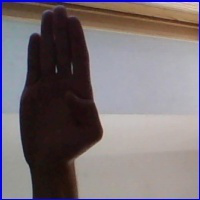
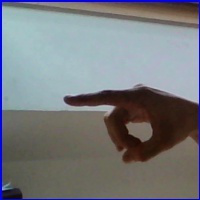
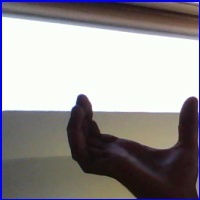
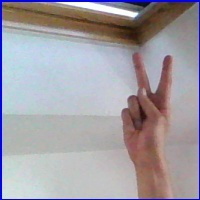
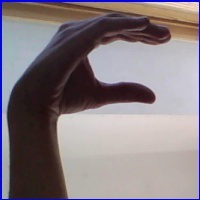
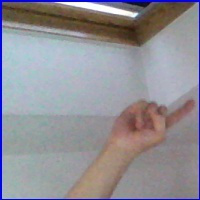
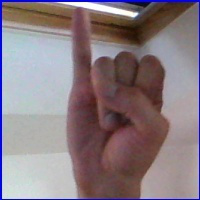
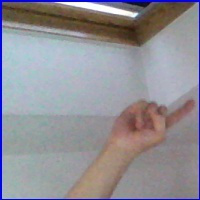
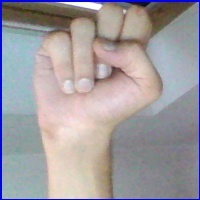
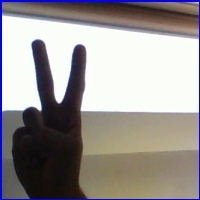
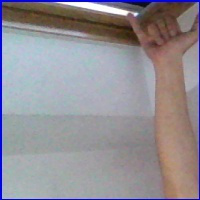
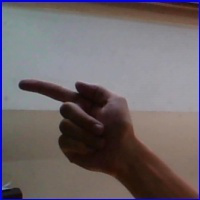
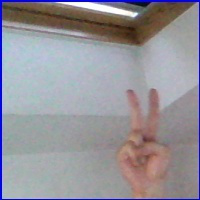
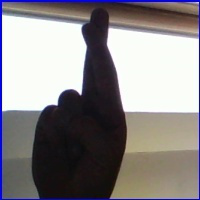
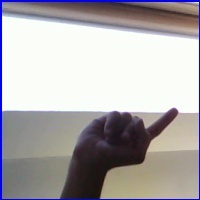
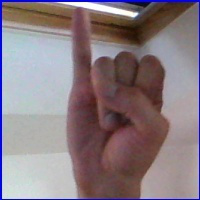


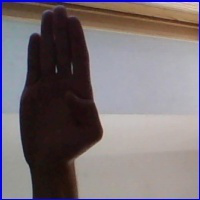
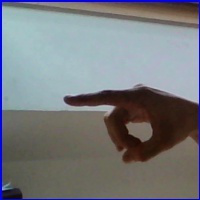
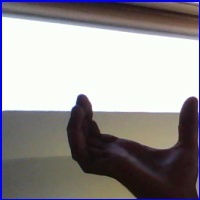
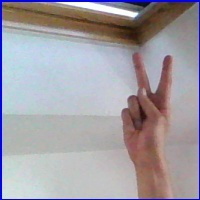
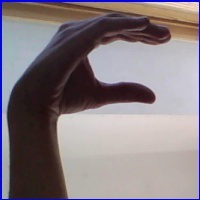
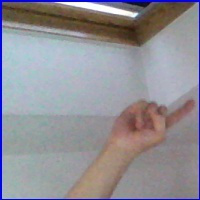
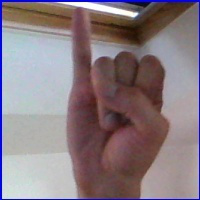
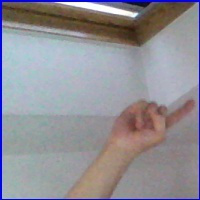
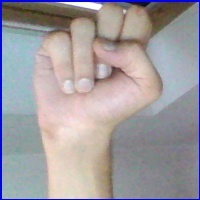
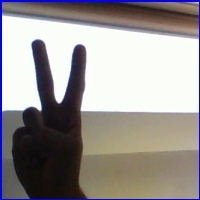
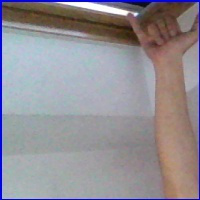
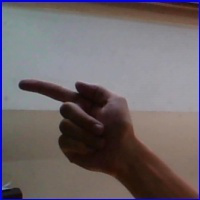
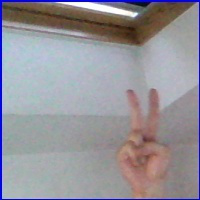
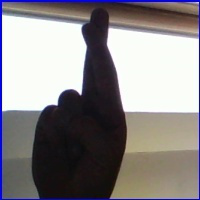
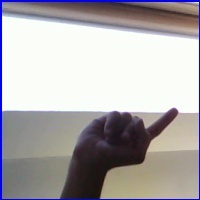
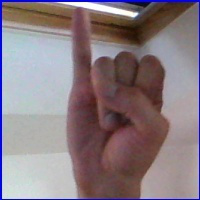

In [ ]:
import random
image_array = []
image_label_array = []
for i in range(16):
  index = random.randint(1,100)
  img = Image.open(image_samples[index])
  image_array.append(img)
  image_label_array.append(image_labels[index])
ipyplot.plot_images(image_array,image_label_array,img_width=200)

## Distribution of labels

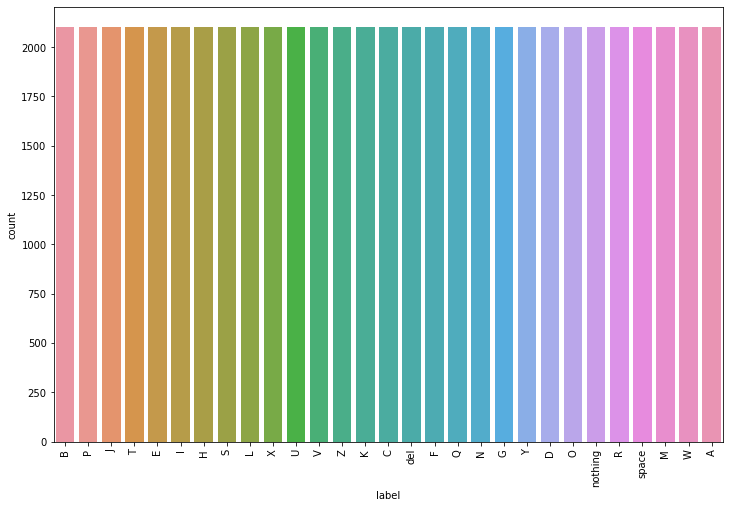

In [ ]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=90)
sns.countplot(x='label',data=train)

* Balanced dataset

## Actual image size

In [8]:
img = cv2.imread(image_samples[0])
img.shape

(200, 200, 3)

## Applying Transfer Learning using Keras

In [9]:
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Input, Lambda, Flatten, TimeDistributed, Activation, MaxPool2D
from tensorflow.keras.layers import Add, Reshape, MaxPooling2D, Concatenate, Embedding, RepeatVector, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import *
#
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
#
import os
import shutil
import cv2
import glob
from tqdm.notebook import tqdm
from tqdm import tqdm
from PIL import Image
#
import gc
#
import warnings
warnings.filterwarnings('ignore')


## Create an instance of the ImageDataGenerator class

In [10]:
batch_size=32
image_shape=(229,229,3)
class_mode='categorical'
dir_path = '/content/content/asl_alphabets/train'

## Train / Validation Data Generator


In [11]:
generator = ImageDataGenerator(rescale=1./255)

## Test Data Generator

In [12]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/content/asl_alphabets/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(229,229))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 26100 validated image filenames.


## Define a function for getting model name in each of the k iterations

In [13]:
def get_model_name(k):
  return 'model_'+str(k)+'.h5'

## Define a function to claibrate F1 Scores

In [15]:
import keras.backend as K
def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [16]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Define Model

In [17]:
train.label.nunique()

29

In [18]:
def create_model():
  model = Sequential()

  conv_base = tf.keras.applications.DenseNet121(input_shape=(229,229,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(29, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model

# Model Traing Evaluation and Predictions
* Train the Model using StartifiedKFold Crossvalidation technique
* Getting the folds and creating the data generators
* Training the model on each Fold and evaluating on the validation fold
* Making the predictions on the test data badsed on the training for the fold
* Saving the predictions for each fold in a list
* Taking the average of all the five predictions made on the basis of each fold for the final predictions

Found 48720 validated image filenames belonging to 29 classes.
Found 12180 validated image filenames belonging to 29 classes.
29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/10
1522/1522 [==============================] - 357s 217ms/step - loss: 12.2177 - accuracy: 0.9354 - get_f1: 0.9179 - val_loss: 3.2402 - val_accuracy: 0.9993 - val_get_f1: 0.9286

Epoch 00001: val_loss improved from inf to 3.24017, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_1.h5
Epoch 2/10
1522/1522 [==============================] - 329s 216ms/step - loss: 2.9855 - accuracy: 0.9935 - get_f1: 0.9887 - val_loss: 2.7010 - val_accuracy: 0.9988 - val_get_f1: 0.9969

Epoch 00002: val_loss improved from 3.24017 to 2.70102, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_1.h5
Epoch 3/10
1522/1522 [==============================] - 330s 217ms/step - loss: 2.6135 - accuracy: 0.9955 - get_f1: 0.9931 - val_loss: 2.4690 - val_accuracy: 0.9975 - val_get_f1: 0.9

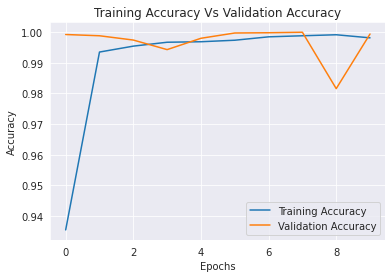

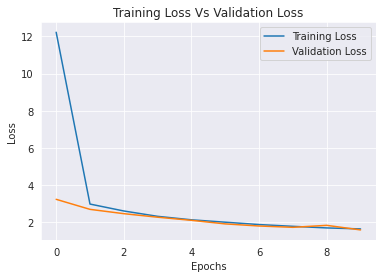

26100/26100 [==============================] - 436s 17ms/step
Found 48720 validated image filenames belonging to 29 classes.
Found 12180 validated image filenames belonging to 29 classes.
Epoch 1/10
1522/1522 [==============================] - 339s 216ms/step - loss: 12.4643 - accuracy: 0.9337 - get_f1: 0.9151 - val_loss: 3.3812 - val_accuracy: 0.9924 - val_get_f1: 0.9319

Epoch 00001: val_loss improved from inf to 3.38122, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_2.h5
Epoch 2/10
1522/1522 [==============================] - 328s 215ms/step - loss: 2.9195 - accuracy: 0.9951 - get_f1: 0.9908 - val_loss: 2.6504 - val_accuracy: 0.9993 - val_get_f1: 0.9938

Epoch 00002: val_loss improved from 3.38122 to 2.65039, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_2.h5
Epoch 3/10
1522/1522 [==============================] - 328s 216ms/step - loss: 2.5556 - accuracy: 0.9961 - get_f1: 0.9941 - val_loss: 2.3141 - val_accuracy: 0.9999 - val_get_f1: 0.9999

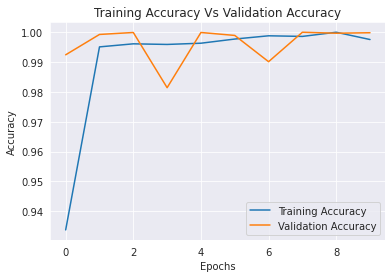

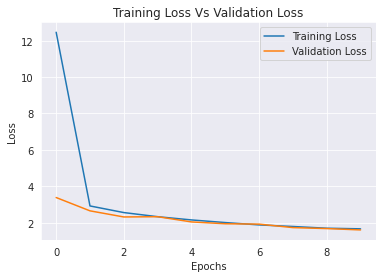

26100/26100 [==============================] - 432s 16ms/step
Found 48720 validated image filenames belonging to 29 classes.
Found 12180 validated image filenames belonging to 29 classes.
Epoch 1/10
1522/1522 [==============================] - 336s 215ms/step - loss: 12.8333 - accuracy: 0.9215 - get_f1: 0.9041 - val_loss: 3.3340 - val_accuracy: 0.9633 - val_get_f1: 0.8656

Epoch 00001: val_loss improved from inf to 3.33400, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_3.h5
Epoch 2/10
1522/1522 [==============================] - 326s 214ms/step - loss: 2.9589 - accuracy: 0.9939 - get_f1: 0.9888 - val_loss: 2.9236 - val_accuracy: 0.9982 - val_get_f1: 0.9964

Epoch 00002: val_loss improved from 3.33400 to 2.92356, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_3.h5
Epoch 3/10
1522/1522 [==============================] - 326s 214ms/step - loss: 2.5533 - accuracy: 0.9976 - get_f1: 0.9966 - val_loss: 3.4650 - val_accuracy: 0.6931 - val_get_f1: 0.5561

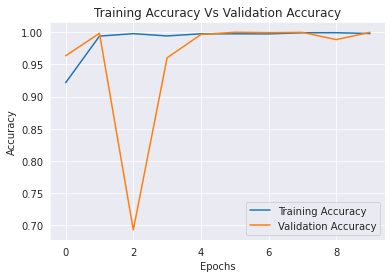

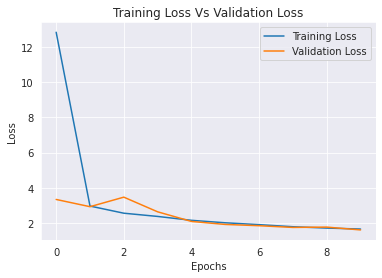

26100/26100 [==============================] - 427s 16ms/step
Found 48720 validated image filenames belonging to 29 classes.
Found 12180 validated image filenames belonging to 29 classes.
Epoch 1/10
1522/1522 [==============================] - 338s 216ms/step - loss: 12.7176 - accuracy: 0.9302 - get_f1: 0.9116 - val_loss: 3.1110 - val_accuracy: 0.9900 - val_get_f1: 0.8738

Epoch 00001: val_loss improved from inf to 3.11102, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_4.h5
Epoch 2/10
1522/1522 [==============================] - 327s 215ms/step - loss: 2.9024 - accuracy: 0.9964 - get_f1: 0.9930 - val_loss: 3.6682 - val_accuracy: 0.9767 - val_get_f1: 0.9732

Epoch 00002: val_loss did not improve from 3.11102
Epoch 3/10
1522/1522 [==============================] - 327s 215ms/step - loss: 2.5983 - accuracy: 0.9945 - get_f1: 0.9922 - val_loss: 2.6632 - val_accuracy: 0.9586 - val_get_f1: 0.9503

Epoch 00003: val_loss improved from 3.11102 to 2.66325, saving model to /co

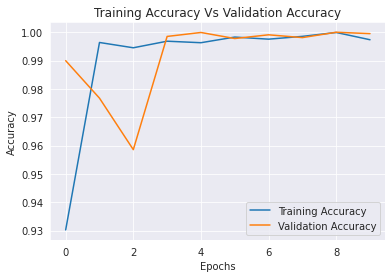

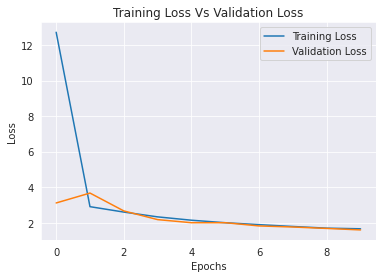

26100/26100 [==============================] - 440s 17ms/step
Found 48720 validated image filenames belonging to 29 classes.
Found 12180 validated image filenames belonging to 29 classes.
Epoch 1/10
1522/1522 [==============================] - 338s 216ms/step - loss: 12.2828 - accuracy: 0.9262 - get_f1: 0.9082 - val_loss: 2.9554 - val_accuracy: 0.9956 - val_get_f1: 0.9496

Epoch 00001: val_loss improved from inf to 2.95543, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_5.h5
Epoch 2/10
1522/1522 [==============================] - 328s 215ms/step - loss: 2.8404 - accuracy: 0.9946 - get_f1: 0.9907 - val_loss: 2.6053 - val_accuracy: 0.9999 - val_get_f1: 0.9997

Epoch 00002: val_loss improved from 2.95543 to 2.60527, saving model to /content/drive/MyDrive/dphi/Sign/saved_model/model_5.h5
Epoch 3/10
1522/1522 [==============================] - 327s 215ms/step - loss: 2.5913 - accuracy: 0.9949 - get_f1: 0.9934 - val_loss: 3.5261 - val_accuracy: 0.7990 - val_get_f1: 0.7741

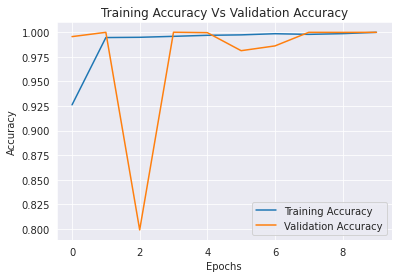

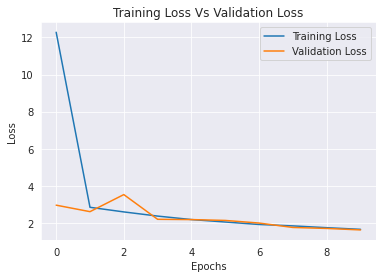

26100/26100 [==============================] - 440s 17ms/step


In [19]:
from keras.models import load_model
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
all_preds = []
dropout=.3
lr=.001
num_epochs = 15
save_dir = '/content/drive/MyDrive/dphi/Sign/saved_model/'
fold_var = 1
n_class = 2
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
#
for train_index, val_index in skf.split(train,train.label):
	training_data = train.iloc[train_index]
	validation_data = train.iloc[val_index]
	
	train_data_generator = generator.flow_from_dataframe(training_data, 
                                                      directory = dir_path,
			 	 	 	                                          x_col = "filename", 
                                                      y_col = "label",
						                                          class_mode = class_mode, 
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      target_size=(229,229))
	valid_data_generator  = generator.flow_from_dataframe(validation_data, 
                                                       directory = dir_path,
							                                          x_col = "filename", 
                                                        y_col = "label",
						                                            class_mode = class_mode, 
                                                        batch_size = 32,
                                                        seed = 42,
                                                        shuffle = True,
                                                        target_size=(229,229))
	
	# CREATE NEW MODEL
	model = create_model()
	# COMPILE NEW MODEL
	model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001,decay=0.0001),
                  metrics=["accuracy",get_f1],
                  loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))
	# CREATE CALLBACKS
	
	my_callbacks = [
               tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor = 'val_loss',verbose = 1,save_weights_only=False, save_best_only = True),
              EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
	]

	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
	STEP_SIZE_TRAIN = train_data_generator.n//train_data_generator.batch_size
	STEP_SIZE_VALID = valid_data_generator.n//valid_data_generator.batch_size
	history = model.fit(
        train_data_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        epochs=10,
        validation_data=valid_data_generator,
        validation_steps= STEP_SIZE_VALID,
        callbacks=[my_callbacks], 
        )
	#PLOT HISTORY
	#		:
	plt.plot(history.history['accuracy'],label='Training Accuracy')
	plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Training Accuracy Vs Validation Accuracy')
	plt.legend()
	plt.show()
  #
	plt.plot(history.history['loss'],label='Training Loss')
	plt.plot(history.history['val_loss'],label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss Vs Validation Loss')
	plt.legend()
	plt.show()
	#		:
	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("/content/drive/MyDrive/dphi/Sign/saved_model/model_"+str(fold_var)+".h5")
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDAITON_LOSS.append(results['loss'])
	preds = model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
	all_preds.append(preds)
	#
	tf.keras.backend.clear_session()
	gc.collect()
	fold_var += 1

## Predictions

In [20]:
# CREATE NEW MODEL
model = create_model()
# COMPILE NEW MODEL
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001,decay=0.0001),
                  metrics=["accuracy",get_f1],
                  loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))

In [22]:
all_preds = []
for fold_var in range(1,6):
  # LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("/content/drive/MyDrive/dphi/Sign/saved_model/model_"+str(fold_var)+".h5")
	preds = model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
	all_preds.append(preds)

26100/26100 [==============================] - 432s 17ms/step


## Final Predictions

In [23]:
final_pred = (all_preds[0] + all_preds[1] + all_preds[2] + all_preds[3] + all_preds[4])/5
predictions = np.argmax(final_pred,axis=1)

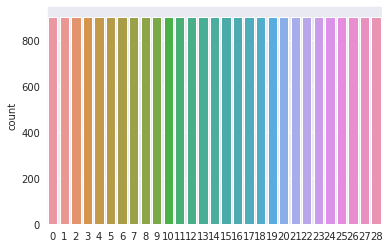

In [24]:
import seaborn as sns
sns.countplot(predictions)

## Prediction Mapper

In [25]:
prediction_mapper = { v: k for k,v in valid_data_generator.class_indices.items()}
prediction_mapper

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'del',
 27: 'nothing',
 28: 'space'}

In [26]:
test['label'] = predictions
test['label'] = test['label'].map(prediction_mapper)
test.head()

filename label
0  Image_1.jpg     M
1  Image_2.jpg     G
2  Image_3.jpg     I
3  Image_4.jpg     E
4  Image_5.jpg     D

In [27]:
sub.head()

label
0     M
1     M
2     M
3     M
4     M

##  Download Predictions

In [29]:
test[['label']].to_csv('Sign_predictions.csv',index=False)

## resul submission scores 
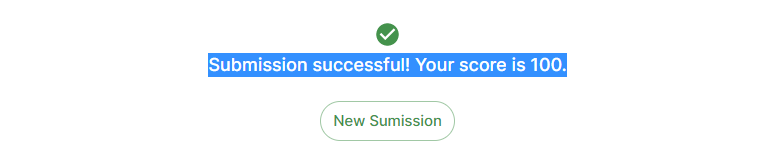

https://dphi.tech/challenges/153/leaderboard/datathon/

## Visualize predictions

In [30]:
image_samples = test['filename'].values.tolist()
image_labels = test['label'].values.tolist()

In [34]:
import random
image_array = []
image_label_array = []
for i in range(16):
  index = random.randint(1,100)
  images = os.path.join("/content/content/asl_alphabets/test",image_samples[index])
  img = Image.open(images)
  image_array.append(img)
  image_label_array.append(image_labels[index])


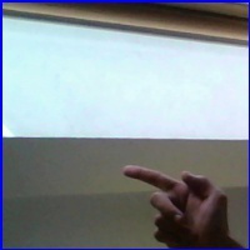
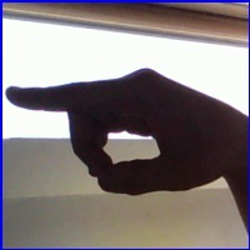
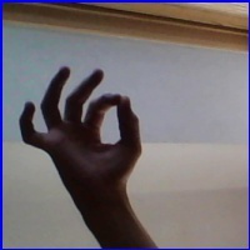
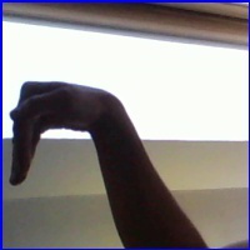
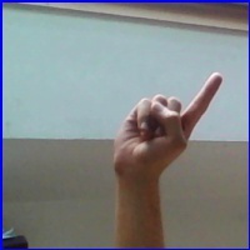
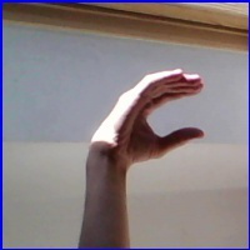
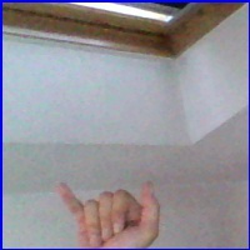
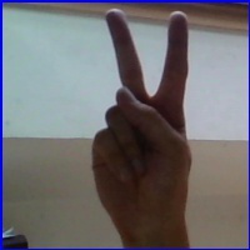
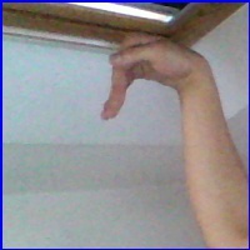
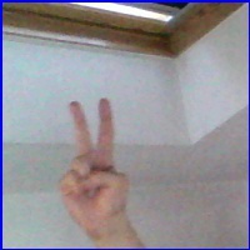
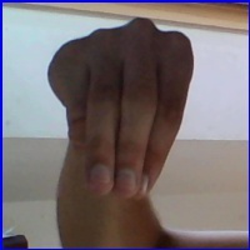
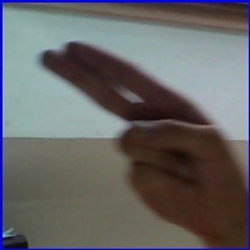
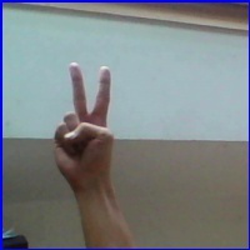
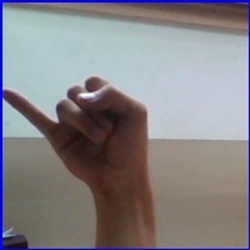
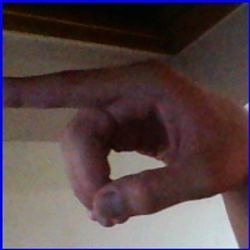
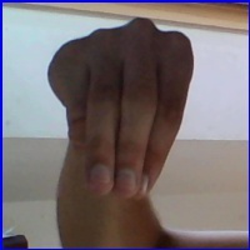


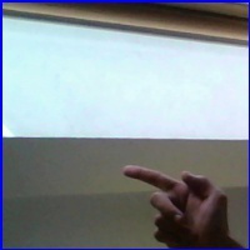
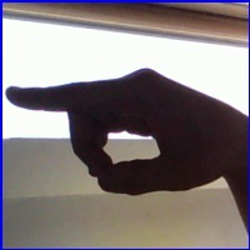
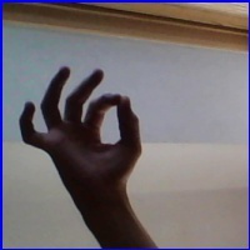
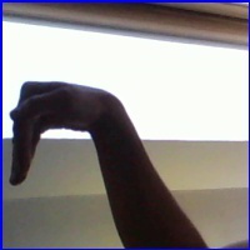
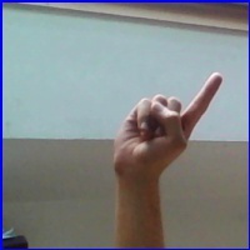
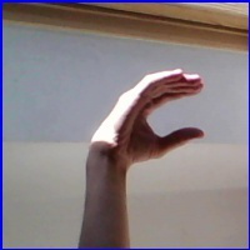
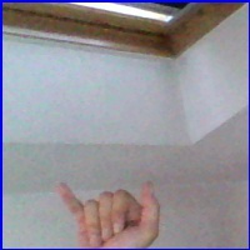
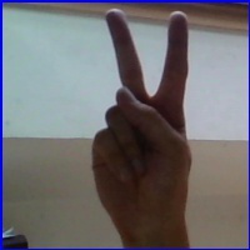
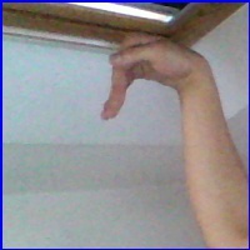
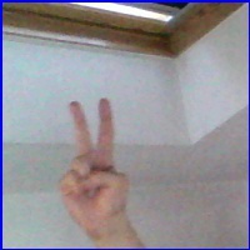
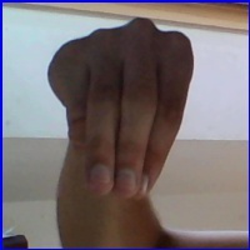
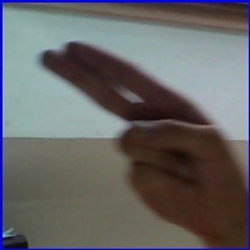
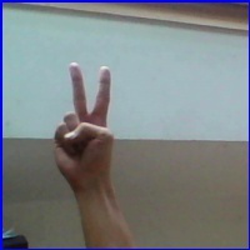
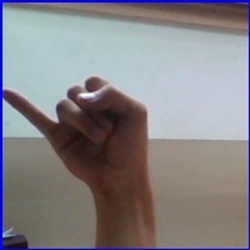
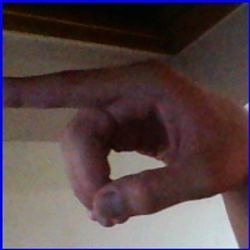
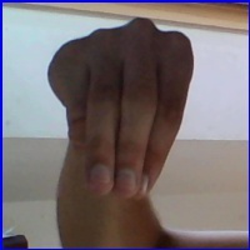

In [35]:
ipyplot.plot_images(image_array,image_label_array,img_width=250)